In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Path to your extracted dataset (change if needed)
original_dataset_path = '/content/drive/MyDrive/output'  # your folder with 'real' and 'fake'
output_base_path = '/content/drive/MyDrive/dataset_split'

# Create folders for train, val, test
splits = ['train', 'val', 'test']
classes = ['real', 'fake']

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_base_path, split, cls), exist_ok=True)

# Function to split and copy files
def split_data(class_name):
    class_path = os.path.join(original_dataset_path, class_name)
    images = os.listdir(class_path)
    images = [img for img in images if img.lower().endswith(('.jpg', '.png', '.jpeg'))]

    random.shuffle(images)

    # Split: 70% train, 15% val, 15% test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Helper to copy files
    def copy_images(img_list, split_name):
        for img in img_list:
            src = os.path.join(class_path, img)
            dst = os.path.join(output_base_path, split_name, class_name, img)
            shutil.copy(src, dst)

    copy_images(train_imgs, 'train')
    copy_images(val_imgs, 'val')
    copy_images(test_imgs, 'test')

# Process both classes
for cls in classes:
    split_data(cls)

print("Dataset split into train/val/test and saved to:", output_base_path)


✅ Dataset split into train/val/test and saved to: /content/drive/MyDrive/dataset_split


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/dataset_split/train'
val_dir = '/content/drive/MyDrive/dataset_split/val'

# Define generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 2559 images belonging to 2 classes.
Found 548 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Keras:", tf.keras.__version__)


TensorFlow: 2.18.0
Keras: 3.8.0


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load base MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenetv2_best_model.h5', save_best_only=True)
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5445 - loss: 0.7506

80/80 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5447 - loss: 0.7502 - val_accuracy: 0.6825 - val_loss: 0.6085
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6234 - loss: 0.6737

80/80 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6237 - loss: 0.6733 - val_accuracy: 0.7190 - val_loss: 0.5656
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6691 - loss: 0.6166

80/80 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.6692 - loss: 0.6165 - val_accuracy: 0.7299 - val_loss: 0.5480
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6898 - loss: 0.5782

80/80 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.6899 - loss: 0.5782 - val_accuracy: 0.7464 - val_loss: 0.5277
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7012 - loss: 0.5849

80/80 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7012 - loss: 0.5849 - val_accuracy: 0.7555 - val_loss: 0.5199
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7064 - loss: 0.5635

80/80 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.7065 - loss: 0.5635 - val_accuracy: 0.7646 - val_loss: 0.5106
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7275 - loss: 0.5480

80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7275 - loss: 0.5479 - val_accuracy: 0.7536 - val_loss: 0.4984
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7283 - loss: 0.5395

80/80 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7283 - loss: 0.5395 - val_accuracy: 0.7555 - val_loss: 0.4935
Epoch 9/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7390 - loss: 0.5187

80/80 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7390 - loss: 0.5187 - val_accuracy: 0.7682 - val_loss: 0.4863
Epoch 10/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7434 - loss: 0.5052

80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7435 - loss: 0.5053 - val_accuracy: 0.7664 - val_loss: 0.4818
Epoch 11/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7369 - loss: 0.4985

80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7370 - loss: 0.4986 - val_accuracy: 0.7774 - val_loss: 0.4716
Epoch 12/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7281 - loss: 0.5218

80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7283 - loss: 0.5216 - val_accuracy: 0.7810 - val_loss: 0.4667
Epoch 13/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7658 - loss: 0.4850 - val_accuracy: 0.7883 - val_loss: 0.4675
Epoch 14/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7625 - loss: 0.4800

80/80 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.7624 - loss: 0.4802 - val_accuracy: 0.7810 - val_loss: 0.4584
Epoch 15/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7645 - loss: 0.4853 - val_accuracy: 0.7755 - val_loss: 0.4595
Epoch 16/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7501 - loss: 0.4888 - val_accuracy: 0.7810 - val_loss: 0.4600
Epoch 17/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7683 - loss: 0.4642

80/80 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7683 - loss: 0.4643 - val_accuracy: 0.7810 - val_loss: 0.4503
Epoch 18/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7668 - loss: 0.4754

80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.7667 - loss: 0.4754 - val_accuracy: 0.7865 - val_loss: 0.4436
Epoch 19/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7479 - loss: 0.4786

80/80 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.7481 - loss: 0.4786 - val_accuracy: 0.7865 - val_loss: 0.4405
Epoch 20/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7698 - loss: 0.4644 - val_accuracy: 0.7682 - val_loss: 0.4422
Epoch 21/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.7669 - loss: 0.4666 - val_accuracy: 0.7974 - val_loss: 0.4413
Epoch 22/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7779 - loss: 0.4633

80/80 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7779 - loss: 0.4634 - val_accuracy: 0.7774 - val_loss: 0.4377
Epoch 23/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7775 - loss: 0.4564

80/80 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.7775 - loss: 0.4564 - val_accuracy: 0.7865 - val_loss: 0.4356
Epoch 24/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7748 - loss: 0.4583

80/80 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.7749 - loss: 0.4583 - val_accuracy: 0.7737 - val_loss: 0.4331
Epoch 25/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7805 - loss: 0.4493

80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7805 - loss: 0.4493 - val_accuracy: 0.7828 - val_loss: 0.4330


In [ ]:
test_dir = '/content/drive/MyDrive/dataset_split/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Evaluate the model
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc*100:.2f}%")

Found 550 images belonging to 2 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7644 - loss: 0.4802
Test Accuracy: 79.82%


In [ ]:
# Save model as .h5 file to Google Drive
model.save('/content/drive/MyDrive/mobilenetv2_deepfake_model.h5')
print("Model saved to Google Drive.")

Model saved to Google Drive.


In [ ]:
from google.colab import files

# Save locally first
model.save('mobilenetv2_deepfake_model.h5')

# Download to your PC
files.download('mobilenetv2_deepfake_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

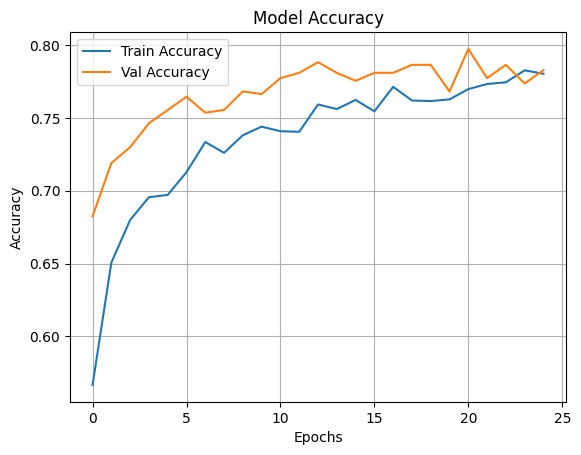

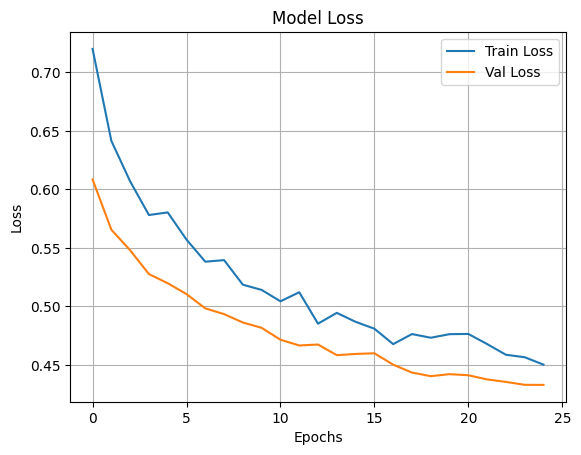

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
Classification Report:
              precision    recall  f1-score   support

        real       0.83      0.74      0.78       269
        fake       0.77      0.85      0.81       281

    accuracy                           0.80       550
   macro avg       0.80      0.80      0.80       550
weighted avg       0.80      0.80      0.80       550



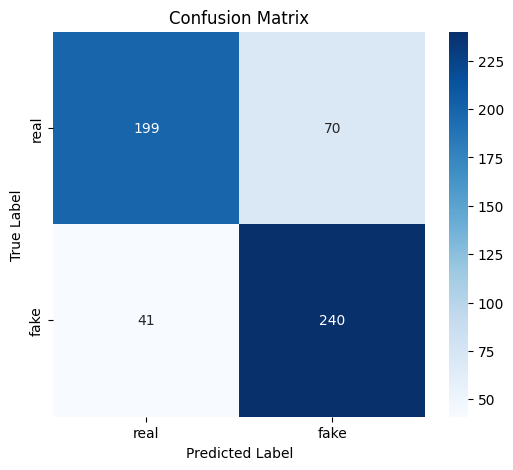

ROC AUC Score: 0.8963


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import seaborn as sns

# Get ground truth and predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["real", "fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["real", "fake"], yticklabels=["real", "fake"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# ROC AUC Score
auc = roc_auc_score(y_true, y_pred_prob)
print(f"ROC AUC Score: {auc:.4f}")

Fine Tuning

In [ ]:
from tensorflow.keras.optimizers import Adam

# Step 1: Unfreeze the top layers (or the whole model if needed)
base_model.trainable = True  # Unfreeze all layers or you can unfreeze top 30 layers as mentioned

# Optionally, unfreeze top layers only (e.g., last 30 layers):
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Step 2: Re-compile the model with a lower learning rate
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-5),  # Low LR for fine-tuning
    metrics=['accuracy']
)

# Step 3: Continue training (fine-tuning) the model
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Continue training for a few more epochs
    callbacks=callbacks  # Early stopping and model checkpoint callbacks
)


Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.5401 - loss: 1.2706 - val_accuracy: 0.7755 - val_loss: 0.4557
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step - accuracy: 0.7280 - loss: 0.5431 - val_accuracy: 0.7883 - val_loss: 0.4666
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.7683 - loss: 0.4869 - val_accuracy: 0.7901 - val_loss: 0.4910
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.7936 - loss: 0.4267 - val_accuracy: 0.7847 - val_loss: 0.5208
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.8149 - loss: 0.3948 - val_accuracy: 0.7701 - val_loss: 0.5431
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8311 - loss: 0.3608 - val_accuracy: 0.7427 - val_loss: 0.6010


In [ ]:
model.save('/content/drive/MyDrive/fine_tuned_mobilenetv2_deepfake.h5')

In [ ]:
from google.colab import files

# Save locally first
model.save('fine_tuned_mobilenetv2_deepfake.h5')

# Download to your PC
files.download('fine_tuned_mobilenetv2_deepfake.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from tensorflow.keras.preprocessing import image

def predict_video(model, video_frame_folder, threshold=0.5):
    frame_files = [f for f in os.listdir(video_frame_folder) if f.endswith('.jpg')]
    frame_files.sort()  # Optional: sort to maintain order

    predictions = []

    for frame in frame_files:
        img_path = os.path.join(video_frame_folder, frame)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        pred_prob = model.predict(img_array)[0][0]
        predictions.append(pred_prob)

    # Average probability across frames
    avg_prob = np.mean(predictions)
    print(f"Average Prediction Probability (Fake): {avg_prob:.4f}")

    if avg_prob >= threshold:
        print("🔴 The video is predicted as: FAKE")
    else:
        print("🟢 The video is predicted as: REAL")


In [ ]:
video_frame_folder = '/content/drive/MyDrive/video_frames'  # Folder with frames like frame1.jpg, frame2.jpg...
predict_video(model, video_frame_folder)